In [ ]:
!pip install mediapipe --user pandas scikit-learn

In [ ]:
!pip install opencv-contrib-python

In [3]:
import mediapipe as mp
import cv2
import csv
import numpy as np
import os
from cv2 import destroyAllWindows

In [4]:
mp_drawing  = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [5]:
class_name = 'Sitting'

## Make Detection

In [6]:
video_file='5_sitting01.mp4'
cap = cv2.VideoCapture(video_file)

# initialize the model
#with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if ret==True:
            
             # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            
            # Make detection
            results = holistic.process(image)
            
            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            #print(results.pose_landmarks)
        
            # pose detection
            #mp_drawing.draw_landmarks(image , results.pose_landmarks , mp_pose.POSE_CONNECTIONS,
            #mp_drawing.DrawingSpec(color=(245,117,66) ,thickness = 2 ,circle_radius=4 ) ,        mp_drawing.DrawingSpec(color=(245,66,230) ,thickness = 2 ,circle_radius=2 ))

            # export coordinates
            try:
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x , landmark.y , landmark.z , landmark.visibility] for landmark in pose]).flatten())

                row = pose_row
                row.insert(0 , class_name)

                with open('sitting-standing.csv' , mode='a',newline='') as f:
                    csv_writer = csv.writer(f , delimiter=',',quotechar='"',quoting = csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)

            except:
                pass
       
    
        
        cv2.imshow('Activity', image)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()

In [7]:
num_coords = len(results.pose_landmarks.landmark)
print(num_coords)

33


## Create Model

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('sitting-standing.csv')

In [9]:
x = df.iloc[: , 1:]
y = df.iloc[: , 0]

In [10]:
X_train , X_test , y_train , y_test = train_test_split(x , y , test_size = 0.4 , random_state=42)

In [11]:
len(X_train) , len(X_test)

(1201, 802)

## Model Preparation

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression , RidgeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [13]:
# Yang digunakan untuk membuat model
pipelines = {
    'knn':make_pipeline( KNeighborsClassifier(5))
}

In [ ]:
list(pipelines.values())[0]

In [16]:
fit_models = {}
for algo , pipeline in pipelines.items():
    model = pipeline.fit(X_train , y_train)
    fit_models[algo] = model
   

## Evaluate Model

In [17]:
#from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

In [ ]:
for algo , model in fit_models.items():
    pred = model.predict(X_test)
    print(algo , accuracy_score(y_test , pred)*100,confusion_matrix(y_test , pred))

In [19]:
# save the model
with open('activity.pkl' , 'wb') as f:
    pickle.dump(fit_models['knn'], f)

# Testing & Make Predictions ( Real Time )

In [20]:
with open('activity.pkl','rb') as f:
    model = pickle.load(f)

In [21]:
import matplotlib.pyplot as plt

In [ ]:
prob_detect=[]
class_detect=[]
result_data = []

video_file='testsitandstand01.mp4'
cap = cv2.VideoCapture(video_file)

# initialize the model
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:

    while cap.isOpened():
        ret , frame = cap.read()
        if ret==True:
            image = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

            image.flags.writeable = False

            results = holistic.process(image)

            # print(results.pose_landmarks)
            image.flags.writeable = True

            image = cv2.cvtColor(image , cv2.COLOR_RGB2BGR)


            # pose detection
            mp_drawing.draw_landmarks(image , results.pose_landmarks , mp_holistic.POSE_CONNECTIONS,
            mp_drawing.DrawingSpec(color=(245,117,66) ,thickness = 2 ,circle_radius=4 ) ,        mp_drawing.DrawingSpec(color=(245,66,230) ,thickness = 2 ,circle_radius=2 ))

            # export coordinates
            try:
                pose = results.pose_landmarks.landmark
                pose_row = list(np.array([[landmark.x , landmark.y , landmark.z , landmark.visibility] for landmark in pose]).flatten())

                row = pose_row
                X = pd.DataFrame([row])
                body_language_class = model.predict(X)[0]
                body_language_prob = model.predict_proba(X)[0]
                                
                cv2.rectangle(image, (0, 0), (250, 60), (245, 117, 16), -1)

                # Display Class
                cv2.putText(image, 'CLASS', (15, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, body_language_class.split(' ')[
                            0], (1, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display Probability
                cv2.putText(image, 'PROB', (175, 12),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)], 2)), (
                    175, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                prob_detect.append(round(body_language_prob[np.argmax(body_language_prob)], 2))
                class_detect.append(body_language_class)
                prob_detect.append(round(body_language_prob[np.argmax(body_language_prob)], 2))
                class_detect.append(body_language_class)
        

                with open('Resultsts03' , mode='a',newline='') as f:
                    csv_writer = csv.writer(f , delimiter=',',quotechar='"',quoting = csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)
            except:
                pass
        result_data.append({"class": body_language_class.split(' ')[0], "probability": round(body_language_prob[np.argmax(body_language_prob)], 2)})
    
        cv2.imshow("Pose Model Detections",image)
        #prob_detect=round(body_language_prob[np.argmax(body_language_prob)], 2)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()

In [24]:
df = pd.read_csv('Resultsts03')

In [26]:
num_coords = len(results.pose_landmarks.landmark)
print(num_coords)

33


In [29]:
import pandas as pd  

frame_rate = 30  # Replace this with the actual frame rate of your video or data

# Calculate the total sum of all probabilities using list comprehension
total_sum_probabilities = sum(result["probability"] for result in result_data)

# Assuming you want to find the percentage sum of probabilities for the class "Transition"
desired_class = "Transition"
desired_class1 = "Standing"
desired_class2 = "Sitting"


# Use list comprehension to filter the data for the desired class
desired_class_data = [(idx, result["class"], result["probability"]) for idx, result in enumerate(result_data) if result["class"] == desired_class]
desired_class_data1 = [(idx, result["class"], result["probability"]) for idx, result in enumerate(result_data) if result["class"] == desired_class1]
desired_class_data2 = [(idx, result["class"], result["probability"]) for idx, result in enumerate(result_data) if result["class"] == desired_class2]

# Calculate the sum of probabilities for the desired class
sum_probabilities = sum(probability for _, _, probability in desired_class_data)
sum_probabilities1 = sum(probability for _, _, probability in desired_class_data1)
sum_probabilities2 = sum(probability for _, _, probability in desired_class_data2)

# Calculate the percentage sum of probabilities for the desired class
percentage_sum_probabilities = (sum_probabilities / total_sum_probabilities) * 100

# Calculate the average probability for the desired class
num_occurrences = len(desired_class_data)
average_probability = (sum_probabilities / num_occurrences) if num_occurrences > 0 else 0
num_occurrences1 = len(desired_class_data1)
average_probability1 = (sum_probabilities1 / num_occurrences1) if num_occurrences1 > 0 else 0
num_occurrences2 = len(desired_class_data2)
average_probability2 = (sum_probabilities2 / num_occurrences2) if num_occurrences2 > 0 else 0

# Convert the index to the time frame using the frame rate
time_frames = [idx / frame_rate for idx, _, _ in desired_class_data]
time_frames1 = [idx / frame_rate for idx, _, _ in desired_class_data1]
time_frames2 = [idx / frame_rate for idx, _, _ in desired_class_data2]

# Create a DataFrame from the filtered data
df_desired_class = pd.DataFrame(desired_class_data, columns=["Index", "Class", "Probability"])
df_desired_class1 = pd.DataFrame(desired_class_data1, columns=["Index", "Class", "Probability"])
df_desired_class2 = pd.DataFrame(desired_class_data2, columns=["Index", "Class", "Probability"])
df_desired_class["Time Frame (seconds)"] = time_frames
df_desired_class1["Time Frame (seconds)"] = time_frames1
df_desired_class2["Time Frame (seconds)"] = time_frames2


print(f"Sum Probabilities for '{desired_class}': {sum_probabilities:.4f}")
print(f"Average Probability for '{desired_class}': {average_probability:.4f}")
print(df_desired_class)
print(f"Sum Probabilities for '{desired_class1}': {sum_probabilities1:.4f}")
print(f"Average Probability for '{desired_class1}': {average_probability1:.4f}")
print(df_desired_class1)
print(f"Sum Probabilities for '{desired_class2}': {sum_probabilities2:.4f}")
print(f"Average Probability for '{desired_class2}': {average_probability2:.4f}")
print(df_desired_class2)


Sum Probabilities for 'Transition': 11.6000
Average Probability for 'Transition': 0.7250
    Index       Class  Probability  Time Frame (seconds)
0     126  Transition          0.6              4.200000
1     127  Transition          0.6              4.233333
2     321  Transition          0.6             10.700000
3     322  Transition          1.0             10.733333
4     323  Transition          0.6             10.766667
5     324  Transition          0.6             10.800000
6     325  Transition          0.6             10.833333
7     385  Transition          0.8             12.833333
8     386  Transition          1.0             12.866667
9     387  Transition          1.0             12.900000
10    388  Transition          0.6             12.933333
11    513  Transition          0.6             17.100000
12    514  Transition          0.8             17.133333
13    516  Transition          0.6             17.200000
14    590  Transition          0.6             19.666667

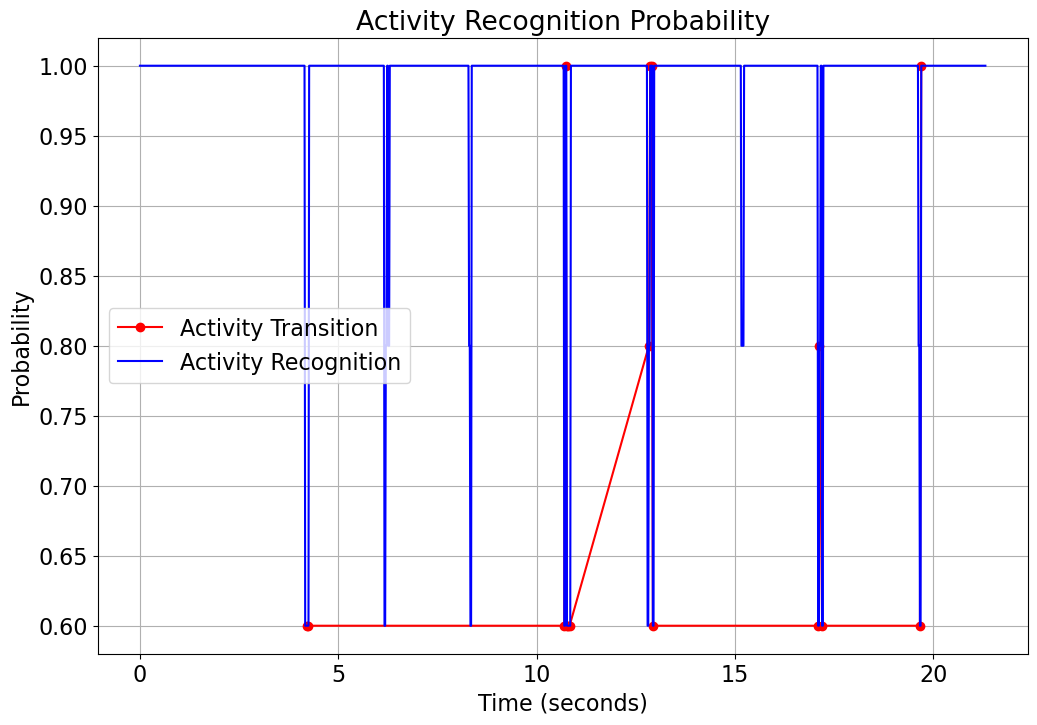

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the frame rate information available
frame_rate = 30 


time_frames = np.array([idx / frame_rate for idx, _, _ in desired_class_data])

# Create a linear plot
plt.figure(figsize=(12, 8))

# Plotting the sum of probabilities for the desired class over time
plt.plot(time_frames, np.array([probability for _, _, probability in desired_class_data]), marker='o', linestyle='-', color='r', label='Activity Transition')

# Plotting the other plot
x = np.arange(0, len(prob_detect), 1)
time = x / 60  # 30 frames per second
plt.plot(time, prob_detect, linestyle='-', color='b', label='Activity Recognition')

# Adding horizontal lines for reference
#plt.axhline(y=0.9, color='g', linestyle='--', label='All Activity')

# Setting labels and title
plt.title("Activity Recognition Probability")
plt.xlabel('Time (seconds)')
plt.ylabel('Probability')

# Adding grid and legend
plt.grid(True)
plt.legend()

# Display the combined plot
plt.show()


In [33]:
labels=['Standing','Transition','Sitting']

In [34]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.rcParams["font.family"] = 'Verdana'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    ax = plt.gca()
    ax.set_ylim(-.5, 5.5)
        
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [35]:
from datetime import datetime
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Reds):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)*100
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(7,7))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, cmap = cm_cmap)
    ax = plt.gca()
    ax.set_ylim(-.2,2.2)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    

In [36]:
from sklearn import linear_model
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

training the model..
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Done 
 

training_time(HH:MM:SS.ms) - 0:00:04.251498


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.046112


---------------------
|      Accuracy      |
---------------------

    100.0


--------------------
| Confusion Matrix |
--------------------

 [[406   0   0]
 [  0 356   0]
 [  0   0  40]]


C:\Users\miduk\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\miduk\AppData\Local\Temp\ipykernel_2004\518412908.py:51: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


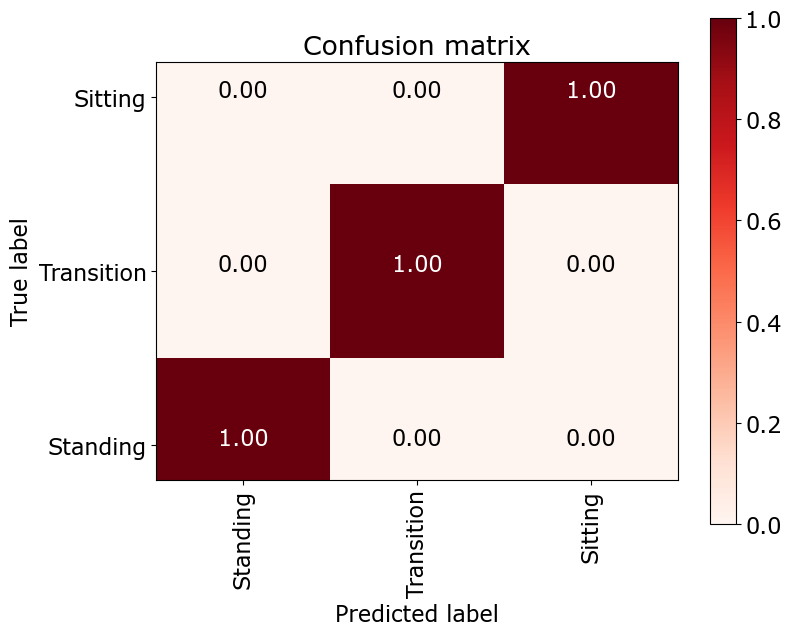

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

     Sitting       1.00      1.00      1.00       406
    Standing       1.00      1.00      1.00       356
  Transition       1.00      1.00      1.00        40

    accuracy                           1.00       802
   macro avg       1.00      1.00      1.00       802
weighted avg       1.00      1.00      1.00       802



In [37]:
from sklearn.neighbors import KNeighborsClassifier

#knn
# start Grid search
parameters = {'n_neighbors': [1, 10, 11, 20, 30]}
log_knn = KNeighborsClassifier(n_neighbors=20)

log_knn_grid = GridSearchCV(log_knn, param_grid=parameters, cv=3, verbose=1, n_jobs=-1)
log_knn_grid_results =  perform_model(log_knn_grid, X_train, y_train, X_test, y_test, class_labels=labels)